# Convolutional Autoencoder 2

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import os 
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.misc import imsave
from scipy.misc import imresize
import numpy as np
from numpy import genfromtxt
import tensorflow as tf
from PIL import Image
import pickle
# from tensorflow_vgg import vgg16|
import collections
import time
import math

# Import GEI dataset 

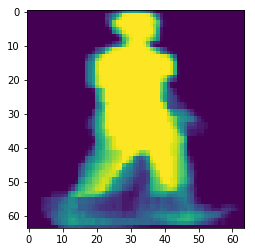

In [2]:
img = imread('{}'.format(os.path.join('OULP-C1V2_Pack/GEI/OULP-GEI-(224x224)-15f/Seq00/0000024', '0000024_55_GEI_15f.png')))
img = imresize(img, [64, 64], interp='nearest')
plt.imshow(img)
plt.show()

In [45]:
# Create Training Data
path = 'OULP-C1V2_Pack/GEI/OULP-GEI-(224x224)/Seq01'
Seq_15f_list = os.listdir(path)
Seq_15f_list.remove('.DS_Store')

Seq = []
for each_seq in Seq_15f_list:
    seq_path = os.path.join(path, each_seq)
    GEI = []
    for each_GEI in os.listdir(seq_path):
        img = imread('{}'.format(os.path.join(seq_path, each_GEI)))
        img = imresize(img, [64, 64], interp='nearest')
        GEI.append(img)
    Seq.append(np.array(GEI))
Seq = np.array(Seq)

In [46]:
with open('../gait_data/OULP_GEI/codes', 'wb') as f:
    np.save(f, Seq)

# Checkpoint 1

In [2]:
# gallery_15f = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_15f_Seq00', mode='rb'))
# probe_15f = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_15f_Seq01', mode='rb'))
gallery_full = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_full_Seq00', mode='rb'))
probe_full = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_full_Seq01', mode='rb'))

In [3]:
gallery_full = gallery_full/float(255)
probe_full = probe_full/float(255)

<br><br><br><br><br><br><br><br><br>

# Auto_Encoder 2: 65''-75''
### 先试full-full

In [4]:
# Train X
train_x = np.concatenate([gallery_full[:2800, 1], probe_full[:2800, 1]], axis=0)
train_x = np.reshape(train_x, [train_x.shape[0], train_x.shape[1], train_x.shape[2], 1])
# Train Y
train_y = np.concatenate([gallery_full[:2800, 2], probe_full[:2800, 2]], axis=0)
train_y = np.reshape(train_x, [train_x.shape[0], train_x.shape[1], train_x.shape[2], 1])
print('train_x', train_x.shape, 'train_y', train_y.shape)

# Val X
val_x = gallery_full[2800:, 1]
val_x = np.reshape(val_x, [val_x.shape[0], val_x.shape[1], val_x.shape[2], 1])
# Val Y
val_y = gallery_full[2800:, 2]
val_y = np.reshape(val_y, [val_y.shape[0], val_y.shape[1], val_y.shape[2], 1])
print('val_x', val_x.shape, 'val_y', val_y.shape)

# Test X
test_x = probe_full[2800:, 1]
test_x = np.reshape(test_x, [test_x.shape[0], test_x.shape[1], test_x.shape[2], 1])
# Test Y
test_y = probe_full[2800:, 2]
test_y = np.reshape(test_x, [test_x.shape[0], test_x.shape[1], test_x.shape[2], 1])
print('test_x', test_x.shape, 'test_y', test_y.shape)

train_x (5600, 64, 64, 1) train_y (5600, 64, 64, 1)
val_x (346, 64, 64, 1) val_y (346, 64, 64, 1)
test_x (346, 64, 64, 1) test_y (346, 64, 64, 1)


# Create Graph

In [5]:
def build_inputs_outputs():
    inputs_1 = tf.placeholder(tf.float32, (None, 64, 64, 1), name='inputs_1')
    targets_1 = tf.placeholder(tf.float32, (None, 64, 64, 1), name='targets_1')
    
    return inputs_1, targets_1

def conv_layer(inputs_, conv_name, pool_name, bn_name, relu_name, add_bacth_norm=True, is_training=True, out_dim=1, 
               kern_size=(2,2), conv_strides=(1,1), pool_size=(2,2), pool_strides=(2,2), keep_prob=0.5):
    ### Encoder
    # e.g. out_dim: 8; kern_size: (3,3); pool_size: (2,2); strides: (2,2);
    conv = tf.layers.conv2d(inputs_, out_dim, kern_size, strides=conv_strides, padding='same', activation=None,
                            name=conv_name)
    # Now 28x28x
    if add_bacth_norm:
        conv = tf.layers.batch_normalization(conv, training=is_training, name=bn_name)
        
    conv = tf.nn.relu(conv, name=relu_name)
        
    maxpool = tf.layers.max_pooling2d(conv, pool_size, pool_strides, padding='same', name=pool_name)
    
    maxpool = tf.layers.dropout(maxpool, rate=keep_prob)

    return maxpool

#     # Now 14x14x16
#     conv2 = tf.layers.conv2d(maxpool1, 8, (3,3), padding='same', activation=tf.nn.relu)
#     # Now 14x14x8
#     maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
#     # Now 7x7x8
#     conv3 = tf.layers.conv2d(maxpool2, 8, (3,3), padding='same', activation=tf.nn.relu)
#     # Now 7x7x8
#     encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
#     # Now 4x4x8

def deconv_layer(encoded, up_name, conv_name, bn_name, relu_name, add_batch_norm=True, is_training=True, 
                 up_size=(2,2), out_dim=1, kern_size=(2,2), conv_strides=(1,1), keep_prob=0.5):
    ### Decoder
    upsample = tf.image.resize_nearest_neighbor(encoded, up_size, name=up_name) # up_size: e.g.(7,7)
    # Now 7x7x8 kern_size: (3, 3)
    conv = tf.layers.conv2d(upsample, out_dim, kern_size, strides=conv_strides, padding='same', activation=None, 
                            name=conv_name) 
    
    if add_batch_norm:
        conv = tf.layers.batch_normalization(conv, training=is_training, name=bn_name)
    
    conv = tf.nn.relu(conv, name=relu_name)
    
    conv = tf.layers.dropout(conv, rate=keep_prob)
    
    return conv

#     # Now 7x7x8
#     upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
#     # Now 14x14x8
#     conv5 = tf.layers.conv2d(upsample2, 8, (3,3), padding='same', activation=tf.nn.relu)
#     # Now 14x14x8
#     upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
#     # Now 28x28x8
#     conv6 = tf.layers.conv2d(upsample3, 16, (3,3), padding='same', activation=tf.nn.relu)
#     # Now 28x28x16

def output_layer(conv, logits_name, bn_name, decoded_name, add_batch_norm=True, is_training=True, 
                 out_dim=1, kern_size=(3,3), conv_strides=(1,1)):
    logits = tf.layers.conv2d(conv, out_dim, kern_size, strides=conv_strides, padding='same', activation=None, 
                              name=logits_name)
    
    if add_batch_norm:
        conv = tf.layers.batch_normalization(conv, training=is_training, name=bn_name)
    #Now 28x28x1
    decoded = tf.nn.sigmoid(logits, name=decoded_name)
    
    return logits, decoded

In [6]:
def build_graph(kern_size, conv_strides, pool_size, pool_strides, de_kern_size, 
                de_conv_strides, out_kern_size, out_strides, up_size=[(16,16), (32,32), (64,64)], is_training=True):
    
    # reset graph
    tf.reset_default_graph()
    
    with tf.name_scope('inputs_targets'):
        inputs_1, targets_1 = build_inputs_outputs()
    
    keep_p = tf.placeholder(tf.float32, name="keep_prob")
    
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    with tf.name_scope('conv_layers'):
        
        maxpool_1 = conv_layer(inputs_1, 'conv_1', 'pool_1', 'bn_1', 'relu_1', add_bacth_norm=False, 
                               is_training=is_training, out_dim=16, kern_size=kern_size, conv_strides=conv_strides, 
                               pool_size=pool_size, pool_strides=pool_strides, keep_prob=keep_p)
        
        maxpool_2 = conv_layer(maxpool_1, 'conv_2', 'pool_2', 'bn_2', 'relu_2', add_bacth_norm=True, 
                               is_training=is_training, out_dim=8, kern_size=kern_size, conv_strides=conv_strides, 
                               pool_size=pool_size, pool_strides=pool_strides, keep_prob=keep_p)
        
        maxpool_3 = conv_layer(maxpool_2, 'conv_3', 'pool_3', 'bn_3', 'relu_3', add_bacth_norm=True, 
                               is_training=is_training, out_dim=8, kern_size=kern_size, conv_strides=conv_strides, 
                               pool_size=pool_size, pool_strides=pool_strides, keep_prob=keep_p)
        
    with tf.name_scope('deconv_layers'):
        
        deconv_1 = deconv_layer(maxpool_3, 'up_1', 'deconv_1', 'de_bn_1', 'de_relu_1', add_batch_norm=True, 
                              is_training=is_training, up_size=up_size[0], out_dim=8, kern_size=de_kern_size,
                              conv_strides=de_conv_strides, keep_prob=keep_p)
        
        deconv_2 = deconv_layer(deconv_1, 'up_2', 'deconv_2', 'de_bn_2', 'de_relu_2', add_batch_norm=True, 
                              is_training=is_training, up_size=up_size[1], out_dim=8, kern_size=de_kern_size,
                              conv_strides=de_conv_strides, keep_prob=keep_p)
        
        deconv_3 = deconv_layer(deconv_2, 'up_3', 'deconv_3', 'de_bn_3', 'de_relu_3', add_batch_norm=True, 
                              is_training=is_training, up_size=up_size[2], out_dim=16, kern_size=de_kern_size,
                              conv_strides=de_conv_strides, keep_prob=keep_p)
        
    with tf.name_scope('output_layer'):
        
        logits, decoded = output_layer(deconv_3, 'logits', 'bn', 'decoded', add_batch_norm=True, is_training=is_training, 
                                       out_dim=1, kern_size=out_kern_size, conv_strides=out_strides)
        
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_1, logits=logits, name='loss')
    cost = tf.reduce_mean(loss, name='cost')
    opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    with tf.name_scope('saver'):
        saver = tf.train.Saver()
        
#     merged = tf.summary.merge_all()
    
    export_nodes = ['inputs_1', 'targets_1', 'maxpool_1', 'maxpool_2', 'maxpool_3', 'deconv_1', 'deconv_2', 
                    'deconv_3', 'logits', 'decoded', 'loss', 'cost', 'opt', 'saver', 'learning_rate', 'keep_p']
    
    Graph = collections.namedtuple('Graph', export_nodes)
    local_dict = locals()
    graph = Graph(*[local_dict[each] for each in export_nodes])
    
    return graph

In [7]:
def get_batches(data, target, batch_size):
    n_batches = len(data)//batch_size
    data = data[:batch_size * n_batches]
    target = target[:batch_size * n_batches]
    for ii in range(0, batch_size*n_batches, batch_size):
        data_batch = data[ii:ii + batch_size]
        target_batch = target[ii:ii + batch_size]
        
        yield data_batch, target_batch
        
        
def cal_accuracy(decoded, target):
    error = abs(decoded - target)
    Acc = (np.sum(error <= 0.15)/(decoded.shape[0]*decoded.shape[1]*decoded.shape[2]*decoded.shape[3]))*100
    
    return Acc

In [8]:
error = np.random.rand(10,5,5,1)
np.sum(error >= 0.9)/100

0.19

In [9]:
def train(model, epochs, save_string):

    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        sess.run(tf.global_variables_initializer())
        
        iteration = 1
        mean_val_loss = 0
        mean_val_acc = 0
        count_loss_not_decrease_epochs = 0
        count_acc_not_decrease_epochs = 0
        Last_val_loss = 0
        Last_val_acc = 0
        
        
        for e in range(epochs):
            for train_batch, target_batch in get_batches(train_x, train_y, batch_size):
                    
                start = time.time()
                
                feed_1 = {
                        model.inputs_1: train_batch, 
                        model.targets_1: target_batch,
                        model.keep_p: 0.5,
                        model.learning_rate: lr
                        }

                train_loss, _, decoded_img = sess.run([model.cost, model.opt, model.decoded], feed_dict=feed_1)
                
                train_acc = cal_accuracy(decoded_img, target_batch)
                
                if iteration%50==0:
                    end = time.time()
#                     acc = calculate_accuracy(sess, pred, target_batch, sq_length)
                    print(
                          "Epoch: {}/{},".format(e+1, epochs),' ',
                          "Iteration: {},".format(iteration),' ',
                          "Train loss: {:.3f},".format(train_loss),' '
                          "{:.1f}s /batch.".format((end-start)/5),' '
                          "Train Accuracy: %{:.3f}".format(train_acc) 
                    )
                                
                ##############################################################
                ######################## VALIDATION ##########################
                ##############################################################
                
                if iteration%100==0:
#                     training = True
                    validation_loss = []
                    validation_acc = []
                    
                    if batch_size >= len(val_x):
                        val_batch_size = len(val_x)
                    else: 
                        val_batch_size = batch_size
                        
#                     ii = 0
                    for ii, (val_batch, val_target_batch) in enumerate(get_batches(val_x, val_y, val_batch_size)):
#                         print(ii, len(val_x)//val_batch_size)
                        feed_2 = {
                                model.inputs_1: val_batch,
                                model.targets_1: val_target_batch,
                                model.keep_p: 1
#                                 model.learning_rate: lr
                                }
                        
                        val_loss, val_decoded_img, max_pool_3 = sess.run([model.cost, model.decoded, model.maxpool_3], 
                                                                          feed_dict=feed_2)
#                         print(val_loss, val_decoded_img)
                        val_acc = cal_accuracy(val_decoded_img, val_target_batch)
                        
                        validation_loss.append(val_loss)
                        validation_acc.append(val_acc)
                        
#                         ii += 1
                        
                        # plot out
#                         if ii == (len(val_x)//val_batch_size) - 1:
#                         fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
#                         in_imgs = val_target_batch[:10]
#                         reconstructed = val_decoded_img[:10]

#                         for images, row in zip([in_imgs, reconstructed], axes):
#                             for img, ax in zip(images, row):
#                                 ax.imshow(img.reshape((64, 64)), cmap='Greys_r')
# #                                 plt.show()
#                                 ax.get_xaxis().set_visible(False)
#                                 ax.get_yaxis().set_visible(False)

#                         fig.tight_layout(pad=0.1)
                            
                    Last_val_loss = mean_val_loss
                    Last_val_acc = mean_val_acc
                    mean_val_loss = np.mean(np.array(validation_loss))
                    mean_val_acc = np.mean(np.array(validation_acc))
                    
                    print()
                    print("Validation loss: {:.3f},".format(mean_val_loss),' '
                          "Validation accuracy: {:.3f},".format(mean_val_acc),' '
                          "maxpool_3.shape: {}.".format(max_pool_3[0].shape))
                    print()
                    
                iteration += 1
                
#             # Early stopping  
#             if mean_val_Acc - Last_val_Acc <= -0.3:
#                 count_Acc_not_increase_epochs += 1
#             if Last_val_loss - mean_val_loss <= -0.01:
#                 count_loss_not_decrease_epochs += 1
                
#             if mean_val_Acc - Last_val_Acc <= -2:
#                 break
#             if count_Acc_not_increase_epochs >= 10:
#                 break
#             if count_loss_not_decrease_epochs >= 10:
#                 break
                
        model.saver.save(sess, r"{}".format(save_string))

In [10]:
!mkdir checkpoints_view_invariant

training = True
num_layers = 3
epochs = 1000
batch_size = 80
conv_kern_size = (3,3)
conv_strides = (1,1)
pool_size = (2,2)
pool_strides = (2,2)
up_size = [(16,16), (32,32), (64,64)]
de_kern_size = (3,3)
de_conv_strides = (1,1)
out_kern_size = (3,3)
out_strides = (1,1)

for lr in [0.001]:
#                 log_string = 'logs/4/lr={},nl={},ls={},bs={}'.format(lr, num_layers, lstm_size, batch_size)
    save_string = './checkpoints_view_invariant/lr={}_nl={}_bs={}.ckpt'.format(lr, num_layers, batch_size)
                
#             writer = tf.summary.FileWriter(log_string)
                                
    model = build_graph(conv_kern_size, conv_strides, pool_size, pool_strides, de_kern_size, de_conv_strides,
                        out_kern_size, out_strides, up_size=up_size, is_training=training)

    train(model, epochs, save_string)
                
    print(' ')
    print(' ')
    print("leraning_rate={},num_layers={},batch_size={} finished, saved".format(lr, num_layers, batch_size))
    print(' ')
    print(' ')

子目录或文件 checkpoints_view_invariant 已经存在。


Epoch: 1/1000,   Iteration: 50,   Train loss: 0.262,  0.0s /batch.  Train Accuracy: %84.496
Epoch: 2/1000,   Iteration: 100,   Train loss: 0.232,  0.0s /batch.  Train Accuracy: %90.904

Validation loss: 0.232,  Validation accuracy: 87.907,  maxpool_3.shape: (8, 8, 8).

Epoch: 3/1000,   Iteration: 150,   Train loss: 0.227,  0.0s /batch.  Train Accuracy: %93.943
Epoch: 3/1000,   Iteration: 200,   Train loss: 0.220,  0.0s /batch.  Train Accuracy: %94.806

Validation loss: 0.218,  Validation accuracy: 91.235,  maxpool_3.shape: (8, 8, 8).

Epoch: 4/1000,   Iteration: 250,   Train loss: 0.223,  0.0s /batch.  Train Accuracy: %95.872
Epoch: 5/1000,   Iteration: 300,   Train loss: 0.211,  0.0s /batch.  Train Accuracy: %96.133

Validation loss: 0.214,  Validation accuracy: 92.046,  maxpool_3.shape: (8, 8, 8).

Epoch: 5/1000,   Iteration: 350,   Train loss: 0.219,  0.0s /batch.  Train Accuracy: %96.891
Epoch: 6/1000,   Iteration: 400,   Train loss: 0.213,  0.0s /batch.  Train Accuracy: %97.154

V

Epoch: 44/1000,   Iteration: 3050,   Train loss: 0.212,  0.0s /batch.  Train Accuracy: %98.969
Epoch: 45/1000,   Iteration: 3100,   Train loss: 0.201,  0.0s /batch.  Train Accuracy: %98.996

Validation loss: 0.207,  Validation accuracy: 94.047,  maxpool_3.shape: (8, 8, 8).

Epoch: 45/1000,   Iteration: 3150,   Train loss: 0.211,  0.0s /batch.  Train Accuracy: %99.055
Epoch: 46/1000,   Iteration: 3200,   Train loss: 0.206,  0.0s /batch.  Train Accuracy: %99.052

Validation loss: 0.212,  Validation accuracy: 92.849,  maxpool_3.shape: (8, 8, 8).

Epoch: 47/1000,   Iteration: 3250,   Train loss: 0.201,  0.0s /batch.  Train Accuracy: %99.115
Epoch: 48/1000,   Iteration: 3300,   Train loss: 0.207,  0.0s /batch.  Train Accuracy: %99.211

Validation loss: 0.206,  Validation accuracy: 93.983,  maxpool_3.shape: (8, 8, 8).

Epoch: 48/1000,   Iteration: 3350,   Train loss: 0.205,  0.0s /batch.  Train Accuracy: %99.047
Epoch: 49/1000,   Iteration: 3400,   Train loss: 0.212,  0.0s /batch.  Train Acc

Epoch: 87/1000,   Iteration: 6050,   Train loss: 0.201,  0.0s /batch.  Train Accuracy: %99.296
Epoch: 88/1000,   Iteration: 6100,   Train loss: 0.206,  0.0s /batch.  Train Accuracy: %99.369

Validation loss: 0.205,  Validation accuracy: 94.100,  maxpool_3.shape: (8, 8, 8).

Epoch: 88/1000,   Iteration: 6150,   Train loss: 0.205,  0.0s /batch.  Train Accuracy: %99.267
Epoch: 89/1000,   Iteration: 6200,   Train loss: 0.211,  0.0s /batch.  Train Accuracy: %99.253

Validation loss: 0.206,  Validation accuracy: 93.898,  maxpool_3.shape: (8, 8, 8).

Epoch: 90/1000,   Iteration: 6250,   Train loss: 0.200,  0.0s /batch.  Train Accuracy: %99.269
Epoch: 90/1000,   Iteration: 6300,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %99.285

Validation loss: 0.206,  Validation accuracy: 94.187,  maxpool_3.shape: (8, 8, 8).

Epoch: 91/1000,   Iteration: 6350,   Train loss: 0.206,  0.0s /batch.  Train Accuracy: %99.263
Epoch: 92/1000,   Iteration: 6400,   Train loss: 0.201,  0.0s /batch.  Train Acc

Epoch: 130/1000,   Iteration: 9050,   Train loss: 0.200,  0.0s /batch.  Train Accuracy: %99.374
Epoch: 130/1000,   Iteration: 9100,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %99.391

Validation loss: 0.207,  Validation accuracy: 94.156,  maxpool_3.shape: (8, 8, 8).

Epoch: 131/1000,   Iteration: 9150,   Train loss: 0.205,  0.0s /batch.  Train Accuracy: %99.417
Epoch: 132/1000,   Iteration: 9200,   Train loss: 0.200,  0.0s /batch.  Train Accuracy: %99.432

Validation loss: 0.208,  Validation accuracy: 93.765,  maxpool_3.shape: (8, 8, 8).

Epoch: 133/1000,   Iteration: 9250,   Train loss: 0.206,  0.0s /batch.  Train Accuracy: %99.464
Epoch: 133/1000,   Iteration: 9300,   Train loss: 0.204,  0.0s /batch.  Train Accuracy: %99.391

Validation loss: 0.206,  Validation accuracy: 94.242,  maxpool_3.shape: (8, 8, 8).

Epoch: 134/1000,   Iteration: 9350,   Train loss: 0.211,  0.0s /batch.  Train Accuracy: %99.366
Epoch: 135/1000,   Iteration: 9400,   Train loss: 0.200,  0.0s /batch.  T

Epoch: 173/1000,   Iteration: 12050,   Train loss: 0.206,  0.0s /batch.  Train Accuracy: %99.517
Epoch: 173/1000,   Iteration: 12100,   Train loss: 0.204,  0.0s /batch.  Train Accuracy: %99.443

Validation loss: 0.206,  Validation accuracy: 94.314,  maxpool_3.shape: (8, 8, 8).

Epoch: 174/1000,   Iteration: 12150,   Train loss: 0.211,  0.0s /batch.  Train Accuracy: %99.428
Epoch: 175/1000,   Iteration: 12200,   Train loss: 0.199,  0.0s /batch.  Train Accuracy: %99.474

Validation loss: 0.206,  Validation accuracy: 94.264,  maxpool_3.shape: (8, 8, 8).

Epoch: 175/1000,   Iteration: 12250,   Train loss: 0.209,  0.0s /batch.  Train Accuracy: %99.475
Epoch: 176/1000,   Iteration: 12300,   Train loss: 0.205,  0.0s /batch.  Train Accuracy: %99.504

Validation loss: 0.210,  Validation accuracy: 93.330,  maxpool_3.shape: (8, 8, 8).

Epoch: 177/1000,   Iteration: 12350,   Train loss: 0.200,  0.0s /batch.  Train Accuracy: %99.499
Epoch: 178/1000,   Iteration: 12400,   Train loss: 0.206,  0.0s /b

Epoch: 215/1000,   Iteration: 15050,   Train loss: 0.209,  0.0s /batch.  Train Accuracy: %99.529
Epoch: 216/1000,   Iteration: 15100,   Train loss: 0.205,  0.0s /batch.  Train Accuracy: %99.557

Validation loss: 0.210,  Validation accuracy: 93.368,  maxpool_3.shape: (8, 8, 8).

Epoch: 217/1000,   Iteration: 15150,   Train loss: 0.200,  0.0s /batch.  Train Accuracy: %99.540
Epoch: 218/1000,   Iteration: 15200,   Train loss: 0.206,  0.0s /batch.  Train Accuracy: %99.565

Validation loss: 0.205,  Validation accuracy: 94.176,  maxpool_3.shape: (8, 8, 8).

Epoch: 218/1000,   Iteration: 15250,   Train loss: 0.204,  0.0s /batch.  Train Accuracy: %99.517
Epoch: 219/1000,   Iteration: 15300,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %99.490

Validation loss: 0.206,  Validation accuracy: 94.004,  maxpool_3.shape: (8, 8, 8).

Epoch: 220/1000,   Iteration: 15350,   Train loss: 0.199,  0.0s /batch.  Train Accuracy: %99.537
Epoch: 220/1000,   Iteration: 15400,   Train loss: 0.209,  0.0s /b

Epoch: 258/1000,   Iteration: 18050,   Train loss: 0.203,  0.0s /batch.  Train Accuracy: %99.556
Epoch: 259/1000,   Iteration: 18100,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %99.515

Validation loss: 0.206,  Validation accuracy: 94.032,  maxpool_3.shape: (8, 8, 8).

Epoch: 260/1000,   Iteration: 18150,   Train loss: 0.199,  0.0s /batch.  Train Accuracy: %99.565
Epoch: 260/1000,   Iteration: 18200,   Train loss: 0.209,  0.0s /batch.  Train Accuracy: %99.579

Validation loss: 0.206,  Validation accuracy: 94.251,  maxpool_3.shape: (8, 8, 8).

Epoch: 261/1000,   Iteration: 18250,   Train loss: 0.205,  0.0s /batch.  Train Accuracy: %99.581
Epoch: 262/1000,   Iteration: 18300,   Train loss: 0.200,  0.0s /batch.  Train Accuracy: %99.586

Validation loss: 0.207,  Validation accuracy: 93.963,  maxpool_3.shape: (8, 8, 8).

Epoch: 263/1000,   Iteration: 18350,   Train loss: 0.205,  0.0s /batch.  Train Accuracy: %99.578
Epoch: 263/1000,   Iteration: 18400,   Train loss: 0.203,  0.0s /b

Epoch: 301/1000,   Iteration: 21050,   Train loss: 0.204,  0.0s /batch.  Train Accuracy: %99.605
Epoch: 302/1000,   Iteration: 21100,   Train loss: 0.200,  0.0s /batch.  Train Accuracy: %99.609

Validation loss: 0.207,  Validation accuracy: 93.990,  maxpool_3.shape: (8, 8, 8).

Epoch: 303/1000,   Iteration: 21150,   Train loss: 0.205,  0.0s /batch.  Train Accuracy: %99.612
Epoch: 303/1000,   Iteration: 21200,   Train loss: 0.203,  0.0s /batch.  Train Accuracy: %99.558

Validation loss: 0.206,  Validation accuracy: 94.344,  maxpool_3.shape: (8, 8, 8).

Epoch: 304/1000,   Iteration: 21250,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %99.541
Epoch: 305/1000,   Iteration: 21300,   Train loss: 0.199,  0.0s /batch.  Train Accuracy: %99.590

Validation loss: 0.206,  Validation accuracy: 94.348,  maxpool_3.shape: (8, 8, 8).

Epoch: 305/1000,   Iteration: 21350,   Train loss: 0.209,  0.0s /batch.  Train Accuracy: %99.592
Epoch: 306/1000,   Iteration: 21400,   Train loss: 0.204,  0.0s /b

Epoch: 344/1000,   Iteration: 24050,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %99.565
Epoch: 345/1000,   Iteration: 24100,   Train loss: 0.199,  0.0s /batch.  Train Accuracy: %99.599

Validation loss: 0.206,  Validation accuracy: 94.320,  maxpool_3.shape: (8, 8, 8).

Epoch: 345/1000,   Iteration: 24150,   Train loss: 0.209,  0.0s /batch.  Train Accuracy: %99.609
Epoch: 346/1000,   Iteration: 24200,   Train loss: 0.204,  0.0s /batch.  Train Accuracy: %99.634

Validation loss: 0.209,  Validation accuracy: 93.449,  maxpool_3.shape: (8, 8, 8).

Epoch: 347/1000,   Iteration: 24250,   Train loss: 0.200,  0.0s /batch.  Train Accuracy: %99.622
Epoch: 348/1000,   Iteration: 24300,   Train loss: 0.205,  0.0s /batch.  Train Accuracy: %99.630

Validation loss: 0.206,  Validation accuracy: 94.191,  maxpool_3.shape: (8, 8, 8).

Epoch: 348/1000,   Iteration: 24350,   Train loss: 0.203,  0.0s /batch.  Train Accuracy: %99.577
Epoch: 349/1000,   Iteration: 24400,   Train loss: 0.210,  0.0s /b

Epoch: 387/1000,   Iteration: 27050,   Train loss: 0.199,  0.0s /batch.  Train Accuracy: %99.639
Epoch: 388/1000,   Iteration: 27100,   Train loss: 0.205,  0.0s /batch.  Train Accuracy: %99.637

Validation loss: 0.206,  Validation accuracy: 94.200,  maxpool_3.shape: (8, 8, 8).

Epoch: 388/1000,   Iteration: 27150,   Train loss: 0.203,  0.0s /batch.  Train Accuracy: %99.592
Epoch: 389/1000,   Iteration: 27200,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %99.581

Validation loss: 0.206,  Validation accuracy: 94.148,  maxpool_3.shape: (8, 8, 8).

Epoch: 390/1000,   Iteration: 27250,   Train loss: 0.199,  0.0s /batch.  Train Accuracy: %99.615
Epoch: 390/1000,   Iteration: 27300,   Train loss: 0.209,  0.0s /batch.  Train Accuracy: %99.622

Validation loss: 0.206,  Validation accuracy: 94.250,  maxpool_3.shape: (8, 8, 8).

Epoch: 391/1000,   Iteration: 27350,   Train loss: 0.204,  0.0s /batch.  Train Accuracy: %99.656
Epoch: 392/1000,   Iteration: 27400,   Train loss: 0.199,  0.0s /b

Epoch: 430/1000,   Iteration: 30050,   Train loss: 0.199,  0.0s /batch.  Train Accuracy: %99.632
Epoch: 430/1000,   Iteration: 30100,   Train loss: 0.209,  0.0s /batch.  Train Accuracy: %99.630

Validation loss: 0.206,  Validation accuracy: 94.229,  maxpool_3.shape: (8, 8, 8).

Epoch: 431/1000,   Iteration: 30150,   Train loss: 0.204,  0.0s /batch.  Train Accuracy: %99.678
Epoch: 432/1000,   Iteration: 30200,   Train loss: 0.199,  0.0s /batch.  Train Accuracy: %99.662

Validation loss: 0.207,  Validation accuracy: 94.023,  maxpool_3.shape: (8, 8, 8).

Epoch: 433/1000,   Iteration: 30250,   Train loss: 0.205,  0.0s /batch.  Train Accuracy: %99.639
Epoch: 433/1000,   Iteration: 30300,   Train loss: 0.203,  0.0s /batch.  Train Accuracy: %99.627

Validation loss: 0.206,  Validation accuracy: 94.296,  maxpool_3.shape: (8, 8, 8).

Epoch: 434/1000,   Iteration: 30350,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %99.597
Epoch: 435/1000,   Iteration: 30400,   Train loss: 0.199,  0.0s /b

Epoch: 473/1000,   Iteration: 33050,   Train loss: 0.205,  0.0s /batch.  Train Accuracy: %99.640
Epoch: 473/1000,   Iteration: 33100,   Train loss: 0.203,  0.0s /batch.  Train Accuracy: %99.650

Validation loss: 0.206,  Validation accuracy: 94.270,  maxpool_3.shape: (8, 8, 8).

Epoch: 474/1000,   Iteration: 33150,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %99.609
Epoch: 475/1000,   Iteration: 33200,   Train loss: 0.199,  0.0s /batch.  Train Accuracy: %99.647

Validation loss: 0.206,  Validation accuracy: 94.323,  maxpool_3.shape: (8, 8, 8).

Epoch: 475/1000,   Iteration: 33250,   Train loss: 0.209,  0.0s /batch.  Train Accuracy: %99.636
Epoch: 476/1000,   Iteration: 33300,   Train loss: 0.204,  0.0s /batch.  Train Accuracy: %99.686

Validation loss: 0.209,  Validation accuracy: 93.550,  maxpool_3.shape: (8, 8, 8).

Epoch: 477/1000,   Iteration: 33350,   Train loss: 0.199,  0.0s /batch.  Train Accuracy: %99.666
Epoch: 478/1000,   Iteration: 33400,   Train loss: 0.205,  0.0s /b

Epoch: 515/1000,   Iteration: 36050,   Train loss: 0.209,  0.0s /batch.  Train Accuracy: %99.645
Epoch: 516/1000,   Iteration: 36100,   Train loss: 0.204,  0.0s /batch.  Train Accuracy: %99.682

Validation loss: 0.209,  Validation accuracy: 93.513,  maxpool_3.shape: (8, 8, 8).

Epoch: 517/1000,   Iteration: 36150,   Train loss: 0.199,  0.0s /batch.  Train Accuracy: %99.677
Epoch: 518/1000,   Iteration: 36200,   Train loss: 0.205,  0.0s /batch.  Train Accuracy: %99.657

Validation loss: 0.206,  Validation accuracy: 94.210,  maxpool_3.shape: (8, 8, 8).

Epoch: 518/1000,   Iteration: 36250,   Train loss: 0.203,  0.0s /batch.  Train Accuracy: %99.659
Epoch: 519/1000,   Iteration: 36300,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %99.623

Validation loss: 0.206,  Validation accuracy: 94.105,  maxpool_3.shape: (8, 8, 8).

Epoch: 520/1000,   Iteration: 36350,   Train loss: 0.199,  0.0s /batch.  Train Accuracy: %99.649
Epoch: 520/1000,   Iteration: 36400,   Train loss: 0.209,  0.0s /b

Epoch: 558/1000,   Iteration: 39050,   Train loss: 0.203,  0.0s /batch.  Train Accuracy: %99.670
Epoch: 559/1000,   Iteration: 39100,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %99.632

Validation loss: 0.206,  Validation accuracy: 94.133,  maxpool_3.shape: (8, 8, 8).

Epoch: 560/1000,   Iteration: 39150,   Train loss: 0.199,  0.0s /batch.  Train Accuracy: %99.658
Epoch: 560/1000,   Iteration: 39200,   Train loss: 0.209,  0.0s /batch.  Train Accuracy: %99.651

Validation loss: 0.206,  Validation accuracy: 94.242,  maxpool_3.shape: (8, 8, 8).

Epoch: 561/1000,   Iteration: 39250,   Train loss: 0.204,  0.0s /batch.  Train Accuracy: %99.691
Epoch: 562/1000,   Iteration: 39300,   Train loss: 0.199,  0.0s /batch.  Train Accuracy: %99.682

Validation loss: 0.207,  Validation accuracy: 94.068,  maxpool_3.shape: (8, 8, 8).

Epoch: 563/1000,   Iteration: 39350,   Train loss: 0.205,  0.0s /batch.  Train Accuracy: %99.666
Epoch: 563/1000,   Iteration: 39400,   Train loss: 0.203,  0.0s /b

Epoch: 601/1000,   Iteration: 42050,   Train loss: 0.204,  0.0s /batch.  Train Accuracy: %99.696
Epoch: 602/1000,   Iteration: 42100,   Train loss: 0.199,  0.0s /batch.  Train Accuracy: %99.698

Validation loss: 0.207,  Validation accuracy: 94.097,  maxpool_3.shape: (8, 8, 8).

Epoch: 603/1000,   Iteration: 42150,   Train loss: 0.205,  0.0s /batch.  Train Accuracy: %99.664
Epoch: 603/1000,   Iteration: 42200,   Train loss: 0.203,  0.0s /batch.  Train Accuracy: %99.674

Validation loss: 0.206,  Validation accuracy: 94.237,  maxpool_3.shape: (8, 8, 8).

Epoch: 604/1000,   Iteration: 42250,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %99.647
Epoch: 605/1000,   Iteration: 42300,   Train loss: 0.199,  0.0s /batch.  Train Accuracy: %99.651

Validation loss: 0.206,  Validation accuracy: 94.340,  maxpool_3.shape: (8, 8, 8).

Epoch: 605/1000,   Iteration: 42350,   Train loss: 0.209,  0.0s /batch.  Train Accuracy: %99.661
Epoch: 606/1000,   Iteration: 42400,   Train loss: 0.204,  0.0s /b

Epoch: 644/1000,   Iteration: 45050,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %99.648
Epoch: 645/1000,   Iteration: 45100,   Train loss: 0.199,  0.0s /batch.  Train Accuracy: %99.664

Validation loss: 0.206,  Validation accuracy: 94.358,  maxpool_3.shape: (8, 8, 8).

Epoch: 645/1000,   Iteration: 45150,   Train loss: 0.209,  0.0s /batch.  Train Accuracy: %99.669
Epoch: 646/1000,   Iteration: 45200,   Train loss: 0.204,  0.0s /batch.  Train Accuracy: %99.696

Validation loss: 0.209,  Validation accuracy: 93.575,  maxpool_3.shape: (8, 8, 8).

Epoch: 647/1000,   Iteration: 45250,   Train loss: 0.199,  0.0s /batch.  Train Accuracy: %99.702
Epoch: 648/1000,   Iteration: 45300,   Train loss: 0.205,  0.0s /batch.  Train Accuracy: %99.667

Validation loss: 0.206,  Validation accuracy: 94.206,  maxpool_3.shape: (8, 8, 8).

Epoch: 648/1000,   Iteration: 45350,   Train loss: 0.203,  0.0s /batch.  Train Accuracy: %99.692
Epoch: 649/1000,   Iteration: 45400,   Train loss: 0.210,  0.0s /b

Epoch: 687/1000,   Iteration: 48050,   Train loss: 0.199,  0.0s /batch.  Train Accuracy: %99.709
Epoch: 688/1000,   Iteration: 48100,   Train loss: 0.205,  0.0s /batch.  Train Accuracy: %99.673

Validation loss: 0.206,  Validation accuracy: 94.197,  maxpool_3.shape: (8, 8, 8).

Epoch: 688/1000,   Iteration: 48150,   Train loss: 0.203,  0.0s /batch.  Train Accuracy: %99.702
Epoch: 689/1000,   Iteration: 48200,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %99.657

Validation loss: 0.206,  Validation accuracy: 94.171,  maxpool_3.shape: (8, 8, 8).

Epoch: 690/1000,   Iteration: 48250,   Train loss: 0.199,  0.0s /batch.  Train Accuracy: %99.662
Epoch: 690/1000,   Iteration: 48300,   Train loss: 0.209,  0.0s /batch.  Train Accuracy: %99.677

Validation loss: 0.206,  Validation accuracy: 94.196,  maxpool_3.shape: (8, 8, 8).

Epoch: 691/1000,   Iteration: 48350,   Train loss: 0.204,  0.0s /batch.  Train Accuracy: %99.705
Epoch: 692/1000,   Iteration: 48400,   Train loss: 0.199,  0.0s /b

Epoch: 730/1000,   Iteration: 51050,   Train loss: 0.198,  0.0s /batch.  Train Accuracy: %99.666
Epoch: 730/1000,   Iteration: 51100,   Train loss: 0.209,  0.0s /batch.  Train Accuracy: %99.679

Validation loss: 0.206,  Validation accuracy: 94.187,  maxpool_3.shape: (8, 8, 8).

Epoch: 731/1000,   Iteration: 51150,   Train loss: 0.204,  0.0s /batch.  Train Accuracy: %99.704
Epoch: 732/1000,   Iteration: 51200,   Train loss: 0.199,  0.0s /batch.  Train Accuracy: %99.718

Validation loss: 0.207,  Validation accuracy: 94.182,  maxpool_3.shape: (8, 8, 8).

Epoch: 733/1000,   Iteration: 51250,   Train loss: 0.205,  0.0s /batch.  Train Accuracy: %99.680
Epoch: 733/1000,   Iteration: 51300,   Train loss: 0.203,  0.0s /batch.  Train Accuracy: %99.712

Validation loss: 0.207,  Validation accuracy: 94.192,  maxpool_3.shape: (8, 8, 8).

Epoch: 734/1000,   Iteration: 51350,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %99.662
Epoch: 735/1000,   Iteration: 51400,   Train loss: 0.198,  0.0s /b

Epoch: 773/1000,   Iteration: 54050,   Train loss: 0.205,  0.0s /batch.  Train Accuracy: %99.689
Epoch: 773/1000,   Iteration: 54100,   Train loss: 0.203,  0.0s /batch.  Train Accuracy: %99.711

Validation loss: 0.206,  Validation accuracy: 94.182,  maxpool_3.shape: (8, 8, 8).

Epoch: 774/1000,   Iteration: 54150,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %99.668
Epoch: 775/1000,   Iteration: 54200,   Train loss: 0.198,  0.0s /batch.  Train Accuracy: %99.663

Validation loss: 0.206,  Validation accuracy: 94.336,  maxpool_3.shape: (8, 8, 8).

Epoch: 775/1000,   Iteration: 54250,   Train loss: 0.209,  0.0s /batch.  Train Accuracy: %99.686
Epoch: 776/1000,   Iteration: 54300,   Train loss: 0.204,  0.0s /batch.  Train Accuracy: %99.704

Validation loss: 0.209,  Validation accuracy: 93.649,  maxpool_3.shape: (8, 8, 8).

Epoch: 777/1000,   Iteration: 54350,   Train loss: 0.199,  0.0s /batch.  Train Accuracy: %99.714
Epoch: 778/1000,   Iteration: 54400,   Train loss: 0.205,  0.0s /b

Epoch: 815/1000,   Iteration: 57050,   Train loss: 0.208,  0.0s /batch.  Train Accuracy: %99.695
Epoch: 816/1000,   Iteration: 57100,   Train loss: 0.204,  0.0s /batch.  Train Accuracy: %99.720

Validation loss: 0.209,  Validation accuracy: 93.654,  maxpool_3.shape: (8, 8, 8).

Epoch: 817/1000,   Iteration: 57150,   Train loss: 0.199,  0.0s /batch.  Train Accuracy: %99.716
Epoch: 818/1000,   Iteration: 57200,   Train loss: 0.205,  0.0s /batch.  Train Accuracy: %99.700

Validation loss: 0.206,  Validation accuracy: 94.174,  maxpool_3.shape: (8, 8, 8).

Epoch: 818/1000,   Iteration: 57250,   Train loss: 0.203,  0.0s /batch.  Train Accuracy: %99.716
Epoch: 819/1000,   Iteration: 57300,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %99.671

Validation loss: 0.206,  Validation accuracy: 94.209,  maxpool_3.shape: (8, 8, 8).

Epoch: 820/1000,   Iteration: 57350,   Train loss: 0.198,  0.0s /batch.  Train Accuracy: %99.668
Epoch: 820/1000,   Iteration: 57400,   Train loss: 0.208,  0.0s /b

Epoch: 858/1000,   Iteration: 60050,   Train loss: 0.203,  0.0s /batch.  Train Accuracy: %99.723
Epoch: 859/1000,   Iteration: 60100,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %99.677

Validation loss: 0.206,  Validation accuracy: 94.219,  maxpool_3.shape: (8, 8, 8).

Epoch: 860/1000,   Iteration: 60150,   Train loss: 0.198,  0.0s /batch.  Train Accuracy: %99.666
Epoch: 860/1000,   Iteration: 60200,   Train loss: 0.208,  0.0s /batch.  Train Accuracy: %99.700

Validation loss: 0.206,  Validation accuracy: 94.160,  maxpool_3.shape: (8, 8, 8).

Epoch: 861/1000,   Iteration: 60250,   Train loss: 0.204,  0.0s /batch.  Train Accuracy: %99.723
Epoch: 862/1000,   Iteration: 60300,   Train loss: 0.199,  0.0s /batch.  Train Accuracy: %99.716

Validation loss: 0.206,  Validation accuracy: 94.286,  maxpool_3.shape: (8, 8, 8).

Epoch: 863/1000,   Iteration: 60350,   Train loss: 0.205,  0.0s /batch.  Train Accuracy: %99.695
Epoch: 863/1000,   Iteration: 60400,   Train loss: 0.203,  0.0s /b

Epoch: 901/1000,   Iteration: 63050,   Train loss: 0.204,  0.0s /batch.  Train Accuracy: %99.689
Epoch: 902/1000,   Iteration: 63100,   Train loss: 0.199,  0.0s /batch.  Train Accuracy: %99.719

Validation loss: 0.206,  Validation accuracy: 94.316,  maxpool_3.shape: (8, 8, 8).

Epoch: 903/1000,   Iteration: 63150,   Train loss: 0.205,  0.0s /batch.  Train Accuracy: %99.704
Epoch: 903/1000,   Iteration: 63200,   Train loss: 0.203,  0.0s /batch.  Train Accuracy: %99.707

Validation loss: 0.206,  Validation accuracy: 94.158,  maxpool_3.shape: (8, 8, 8).

Epoch: 904/1000,   Iteration: 63250,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %99.680
Epoch: 905/1000,   Iteration: 63300,   Train loss: 0.198,  0.0s /batch.  Train Accuracy: %99.680

Validation loss: 0.206,  Validation accuracy: 94.402,  maxpool_3.shape: (8, 8, 8).

Epoch: 905/1000,   Iteration: 63350,   Train loss: 0.208,  0.0s /batch.  Train Accuracy: %99.695
Epoch: 906/1000,   Iteration: 63400,   Train loss: 0.204,  0.0s /b

Epoch: 944/1000,   Iteration: 66050,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %99.685
Epoch: 945/1000,   Iteration: 66100,   Train loss: 0.198,  0.0s /batch.  Train Accuracy: %99.694

Validation loss: 0.206,  Validation accuracy: 94.415,  maxpool_3.shape: (8, 8, 8).

Epoch: 945/1000,   Iteration: 66150,   Train loss: 0.208,  0.0s /batch.  Train Accuracy: %99.693
Epoch: 946/1000,   Iteration: 66200,   Train loss: 0.204,  0.0s /batch.  Train Accuracy: %99.705

Validation loss: 0.209,  Validation accuracy: 93.624,  maxpool_3.shape: (8, 8, 8).

Epoch: 947/1000,   Iteration: 66250,   Train loss: 0.199,  0.0s /batch.  Train Accuracy: %99.719
Epoch: 948/1000,   Iteration: 66300,   Train loss: 0.205,  0.0s /batch.  Train Accuracy: %99.706

Validation loss: 0.206,  Validation accuracy: 94.219,  maxpool_3.shape: (8, 8, 8).

Epoch: 948/1000,   Iteration: 66350,   Train loss: 0.203,  0.0s /batch.  Train Accuracy: %99.718
Epoch: 949/1000,   Iteration: 66400,   Train loss: 0.210,  0.0s /b

Epoch: 987/1000,   Iteration: 69050,   Train loss: 0.199,  0.0s /batch.  Train Accuracy: %99.727
Epoch: 988/1000,   Iteration: 69100,   Train loss: 0.205,  0.0s /batch.  Train Accuracy: %99.706

Validation loss: 0.205,  Validation accuracy: 94.246,  maxpool_3.shape: (8, 8, 8).

Epoch: 988/1000,   Iteration: 69150,   Train loss: 0.203,  0.0s /batch.  Train Accuracy: %99.719
Epoch: 989/1000,   Iteration: 69200,   Train loss: 0.210,  0.0s /batch.  Train Accuracy: %99.692

Validation loss: 0.206,  Validation accuracy: 94.226,  maxpool_3.shape: (8, 8, 8).

Epoch: 990/1000,   Iteration: 69250,   Train loss: 0.198,  0.0s /batch.  Train Accuracy: %99.685
Epoch: 990/1000,   Iteration: 69300,   Train loss: 0.208,  0.0s /batch.  Train Accuracy: %99.700

Validation loss: 0.206,  Validation accuracy: 94.177,  maxpool_3.shape: (8, 8, 8).

Epoch: 991/1000,   Iteration: 69350,   Train loss: 0.204,  0.0s /batch.  Train Accuracy: %99.712
Epoch: 992/1000,   Iteration: 69400,   Train loss: 0.199,  0.0s /b

<br><br><br><br><br><br><br><br><br>

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

## Training

As before, here wi'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [6]:
sess = tf.Session()

In [ ]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

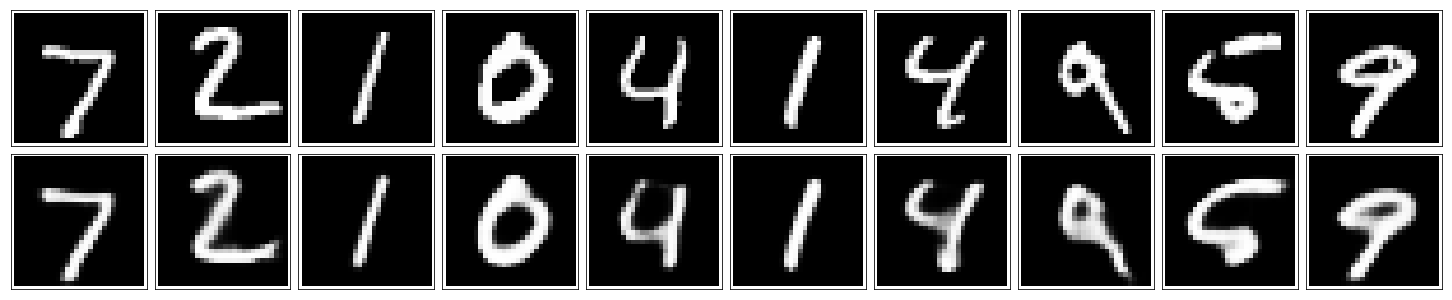

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [19]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [21]:
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# Now 14x14x32
conv2 = tf.layers.conv2d(maxpool1, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
# Now 7x7x32
conv3 = tf.layers.conv2d(maxpool2, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x16
conv4 = tf.layers.conv2d(upsample1, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
# Now 14x14x16
conv5 = tf.layers.conv2d(upsample2, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x32
conv6 = tf.layers.conv2d(upsample3, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
#Now 28x28x1

decoded = tf.nn.sigmoid(logits, name='decoded')

loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(0.001).minimize(cost)

In [22]:
sess = tf.Session()

In [ ]:
epochs = 100
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprising great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

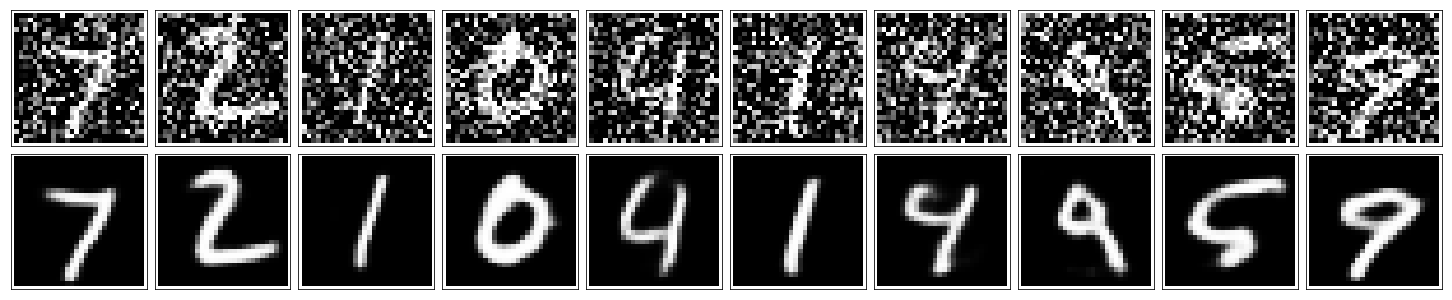

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)